# Extracting a sub cube from the sparkfits_images table

This notebook demonstrates the procedure to create a sub cube from the main FITS file saved on Parquet. It has been laid out as a point by point demonstration on how to interact with the image tables that have been created in Parquet on HDFS, with a Hive metadata layer to allow access by Hive QL.




#### Changing the Spark context to increase resources
The next two cells demonstrate how to re initialise the spark context within a Jupyter notebook when more resources are allocated. Usually, this is not required; so these cells are only included for information.


In [1]:
newContext=False

In [2]:
if newContext:
    # Set the new configuration
    print("Loading new Spark configuration")
    conf = SparkConf().setAll([('spark.executor.memory', '8g'),\
                               ('spark.driver.memory', '6g'),\
                               ('spark.shuffle.service.enabled', True), \
                               ('spark.sql.shuffle.partitions', 144), \
                               ('spark.default.parallelism', 144),\
                               ('spark.dynamicAllocation.enabled', True), \
                               ('spark.dynamicAllocation.executorIdleTimeout', 600), \
                               ('spark.executor.cores', 4),\
                               ('spark.executor.instances', 25), \
                               ('spark.local.dir','/mnt/FITs/Spark/tmp'),\
                               ('spark.executor.memoryOverhead', '6g'),\
                               ('spark.driver.memoryOverhead', '4g'),\
                               ('spark.rpc.message.maxSize', '512'),\
                               ('spark.scheduler.mode', 'FAIR'),\
                               ('spark.kryoserializer.buffer.max', '1g'),\
                               ('spark.hadoop.hive.exec.dynamic.partition', True), \
                               ('spark.hadoop.hive.exec.dynamic.partition.mode','nonstrict'), \
                               ('spark.hadoop.hive.exec.max.dynamic.partitions', 100000), \
                               ('spark.hadoop.hive.exec.max.dynamic.partitions.pernode', 100000), \
                               ('spark.app.name','Creating FITs dimensions')])

    # Stop the old context
    sc.stop()

    # And restart the context with the new configuration
    sc = SparkContext(conf=conf)
    sqlContext = SQLContext(sc)
    newContext=True

In [3]:
sc

<SparkContext master=yarn appName=pyspark-shell>

In [4]:
sqlContext

## Import the necessary libraries

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
plt.style.use(astropy_mpl_style)

import numpy as np
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from scipy import sparse
from scipy.sparse import csr_matrix

from random import randint
from time import sleep

from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from reproject import reproject_interp
import astropy.units as u

from pyspark.sql import SQLContext, SparkSession
from pyspark import StorageLevel

from pyspark import SparkFiles

from pyspark.sql import functions as F
import pyspark.sql.functions as f

from pyspark.sql.functions import randn, monotonically_increasing_id, row_number, desc, udf, col, lit
from pyspark.sql.functions import broadcast
from pyspark.sql.types import ArrayType, FloatType,IntegerType, DataType, DoubleType,Row, BooleanType

"""
Set the Spark datatypes
"""
iType=IntegerType()
dType=DoubleType()
fType=FloatType()

from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.window import Window

from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector,VectorUDT

from datetime import datetime

maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache


## Class definitions

In [6]:
from time import time, clock
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
        self.t1=clock()
        self.elapsed = 1
        self.elapsedCPU = 1
    
    def start(self):
        self.t0=time()
        self.t1=clock()
        
    def stop(self):
        t1=time()
        t2=clock()
        print("Elapsed {:2.1f}s, CPU {:2.1f}s".format(t1-self.t0, t2-self.t1))
        self.elapsed = t1-self.t0
        self.elapsedCPU = t2-self.t1

timer=Timer()

## Function and UDF definitions

### Functions

In [9]:
def GetDetailArrays(fitsFilename, raType, decType, spectraType):
    sqlStmt=("""
        select sda_detail_array, sda_detail_type
        from Sparkfits_detail_arrays
        where sda_filename='{}'
    """).format(fitsFilename)

    detailsDF=sqlContext.sql(sqlStmt)
    
    raArray=np.array(detailsDF.filter(f.col("sda_detail_type") == raType)\
                     .select(f.col("sda_detail_array")).collect() )
    raArray=raArray.reshape(raArray.shape[2])

    decArray=np.array(detailsDF.filter(f.col("sda_detail_type") == decType)\
                      .select(f.col("sda_detail_array")).collect() )
    decArray=decArray.reshape(decArray.shape[2])

    spectraArray=np.array(detailsDF.filter(f.col("sda_detail_type") == spectraType)\
                          .select(f.col("sda_detail_array")).collect() )
    spectraArray=spectraArray.reshape(spectraArray.shape[2])

    return raArray, decArray, spectraArray

In [10]:
## Nice utilities from Joe Filippazzo
## http://www.bdnyc.org/2012/10/decimal-deg-to-hms/

def deg2HMS(ra='', dec='', round=False):
  RA, DEC, rs, ds = '', '', '', ''
  if dec:
    if str(dec)[0] == '-':
      ds, dec = '-', abs(dec)
    deg = int(dec)
    decM = abs(int((dec-deg)*60))
    if round:
      decS = int((abs((dec-deg)*60)-decM)*60)
    else:
      decS = (abs((dec-deg)*60)-decM)*60
    DEC = '{0}{1} {2} {3}'.format(ds, deg, decM, decS)
  
  if ra:
    if str(ra)[0] == '-':
      rs, ra = '-', abs(ra)
    raH = int(ra/15)
    raM = int(((ra/15)-raH)*60)
    if round:
      raS = int(((((ra/15)-raH)*60)-raM)*60)
    else:
      raS = ((((ra/15)-raH)*60)-raM)*60
    RA = '{0}{1} {2} {3}'.format(rs, raH, raM, raS)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

def HMS2deg(ra='', dec=''):
  RA, DEC, rs, ds = '', '', 1, 1
  if dec:
    D, M, S = [float(i) for i in dec.split()]
    if str(D)[0] == '-':
      ds, D = -1, abs(D)
    deg = D + (M/60) + (S/3600)
    DEC = '{0}'.format(deg*ds)
  
  if ra:
    H, M, S = [float(i) for i in ra.split()]
    if str(H)[0] == '-':
      rs, H = -1, abs(H)
    deg = (H*15) + (M/4) + (S/240)
    RA = '{0}'.format(deg*rs)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

## Set up the connection to Hive on HDFS

Set default database to the default Hive database - in this case, "fits_investigation". This example displays the available databases, sets the default database and then shows the database tables.

In [16]:
sqlContext.sql("show databases").show()
sqlContext.sql("use fits_investigation")
sqlContext.sql("show tables").show()


+------------------+
|      databaseName|
+------------------+
|            claran|
|           default|
|fits_investigation|
|     gravity_waves|
|          plasticc|
+------------------+

+------------------+--------------------+-----------+
|          database|           tableName|isTemporary|
+------------------+--------------------+-----------+
|fits_investigation|          array_test|      false|
|fits_investigation|    fits_header_data|      false|
|fits_investigation|          float_test|      false|
|fits_investigation|  imagetestsparkfits|      false|
|fits_investigation|   localparalleltest|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|  newdfdeletemelater|      false|
|fits_investigation|     parquetdataview|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|


## Data extraction

### Get the files we have loaded into Parquet

In [17]:
filesDF=sqlContext.sql("""
    show partitions sparkfits_detail_arrays
""")
filesDF.show(80, False)

+---------------------------------------------------------------------------------------+
|partition                                                                              |
+---------------------------------------------------------------------------------------+
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=DEC--SIN              |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=GHz                   |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=Hz                    |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=RA---SIN              |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=km s-1                |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=DEC--SIN              |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=GHz                   |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=Hz                    |
|sda_filen

## Set selection variables

We determine which file, coordinate system and spectra type

In [18]:
fitsFilename='image.restored.i.SB2338.V2.cube.fits'
raType='RA---SIN'
decType='DEC--SIN'
spectraType='Hz'

## Create the header from the initial FITS file
Which is saved in the table "fits_header_data". This table is comprised of the header cards from the original file header saved with an index value to keep them in the original order when being retrieved. The schema of the table and an example listing is shown in the next cell. 

In [19]:
sqlContext.sql("describe fits_header_data").show()
sqlContext.sql("select * from fits_header_data order by index").show(20, False)

+---------+---------+-------+
| col_name|data_type|comment|
+---------+---------+-------+
|fits_file|   string|   null|
|    index|   bigint|   null|
|      key|   string|   null|
|    value|   string|   null|
|  comment|   string|   null|
+---------+---------+-------+

+------------------------------------+-----+-------+---------------+-------------------------------+
|fits_file                           |index|key    |value          |comment                        |
+------------------------------------+-----+-------+---------------+-------------------------------+
|image.restored.i.SB2338.V2.cube.fits|0    |SIMPLE |True           |Standard FITS                  |
|image.restored.i.SB2338.V2.cube.fits|1    |BITPIX |-32            |Floating point (32 bit)        |
|image.restored.i.SB2338.V2.cube.fits|2    |NAXIS  |4              |                               |
|image.restored.i.SB2338.V2.cube.fits|3    |NAXIS1 |5607           |                               |
|image.restored.i.SB23

We'll create the original header from the image.restored.i.SB2338.V2.cube.fits cube file. We've already set the filename we're interested in, so lets extract the data and create the header file.

#### Get the data cards from Parquet and create the header
For clarity, we create a SQL statement we can run against the Hive tables, and we substitute the filename we're interested in.

In [20]:
sqlStmt=("""
            select * 
            from fits_header_data
            where fits_file='{}'
            order by index""".format(fitsFilename)
        )

Create the header dataframe

In [21]:
hduData=sqlContext.sql(sqlStmt)
hduData.show()


+--------------------+-----+-------+---------------+--------------------+
|           fits_file|index|    key|          value|             comment|
+--------------------+-----+-------+---------------+--------------------+
|image.restored.i....|    0| SIMPLE|           True|       Standard FITS|
|image.restored.i....|    1| BITPIX|            -32|Floating point (3...|
|image.restored.i....|    2|  NAXIS|              4|                    |
|image.restored.i....|    3| NAXIS1|           5607|                    |
|image.restored.i....|    4| NAXIS2|           5654|                    |
|image.restored.i....|    5| NAXIS3|              1|                    |
|image.restored.i....|    6| NAXIS4|           2592|                    |
|image.restored.i....|    7| BSCALE|            1.0|PHYSICAL = PIXEL*...|
|image.restored.i....|    8|  BZERO|            0.0|                    |
|image.restored.i....|   10|  BUNIT|        Jy/beam|Brightness (pixel...|
|image.restored.i....|   11|EQUINOX|  

Now that we have the original FITS header cards in the dataframe, we create the original header.

The RetrieveHeader function takes the dataframe we just created as a parameter. We create a new blank fits header, and then use the dataframe to create the cards in the recreated dataframe.

In [22]:
def RetrieveHeader(df):
    # Create header file

    hdu=fits.PrimaryHDU()
    hduHeader=hdu.header

    def isFloat(string):
        try:
            float(string)
            return True
        except ValueError:
            return False
    for row in hduData.rdd.toLocalIterator():

        if row.value=='True':
            v=True
        elif isFloat(row.value):
            v=float(row.value)
            pass
        elif row.value.isnumeric():
            v=int(row.value)
            pass
        else:
            v=row.value
        #print(row.key, v) #row.value, row.value.isnumeric(), isFloat(row.value), bool(row.value))
        hduHeader[row.key] = (v, row.comment)
        pass
    
    return hduHeader

retrievedHeader = RetrieveHeader(hduData)
retrievedHeader


SIMPLE  =                    T / Standard FITS                                  
BITPIX  =                -32.0 / Floating point (32 bit)                        
NAXIS   =                  4.0                                                  
EXTEND  =                    T                                                  
NAXIS1  =               5607.0                                                  
NAXIS2  =               5654.0                                                  
NAXIS3  =                  1.0                                                  
NAXIS4  =               2592.0                                                  
BSCALE  =                  1.0 / PHYSICAL = PIXEL*BSCALE + BZERO                
BZERO   =                  0.0                                                  
BUNIT   = 'Jy/beam '           / Brightness (pixel) unit                        
EQUINOX =               2000.0                                                  
RADESYS = 'FK5     '        

## Get the sub cube data we want

### Example 1 - full 5607 x 5654 images, for three channels

First, lets describe the table so we know what we're dealing with


In [23]:
sqlContext.sql("desc sparkfits_images").show()

+--------------------+------------+-------+
|            col_name|   data_type|comment|
+--------------------+------------+-------+
|           spi_index|         int|   null|
|           spi_image|array<float>|   null|
|        spi_filename|      string|   null|
|            spi_band|         int|   null|
|# Partition Infor...|            |       |
|          # col_name|   data_type|comment|
|        spi_filename|      string|   null|
|            spi_band|         int|   null|
+--------------------+------------+-------+



As an example, lets assume we're interested in the 14th through 16th channels.

#### Important!

Include the "order by clause" as spark, unlike a relational database, has no concept of data order when it returns a dataframe from Parquet.

In [24]:
newCubeDF=sqlContext.sql("""
select spi_image
from sparkfits_images
where spi_filename='{}'
and spi_band in (14,15,16)
order by spi_index
""".format(fitsFilename))

Lets have a look at the explain plan.

In [25]:
sqlContext.sql("""
select spi_image
from sparkfits_images
where spi_filename='{}'
and spi_band in (14, 15, 16)
""".format(fitsFilename)).explain(False)

== Physical Plan ==
*(1) Project [spi_image#124]
+- *(1) FileScan parquet fits_investigation.sparkfits_images[spi_image#124,spi_filename#125,spi_band#126] Batched: false, Format: Parquet, Location: PrunedInMemoryFileIndex[hdfs://athena-1.nimbus.pawsey.org.au:8020/user/hive/warehouse/fits_invest..., PartitionCount: 3, PartitionFilters: [isnotnull(spi_filename#125), (spi_filename#125 = image.restored.i.SB2338.V2.cube.fits), spi_band..., PushedFilters: [], ReadSchema: struct<spi_image:array<float>>


What we can see here is the physical partitioning at work - the PrunedInMemoryFileIndex and PartitionFilters statements show us that we're only reading data from the specified physical partitions. Lets continue.

#### Now we need to collect the data from the dataframe.

In [26]:
data=np.array(newCubeDF.select(col('spi_image')).collect())

In [27]:
data.shape

(16962, 1, 5607)

Now we need to reshape the array into the original format

In [28]:
data=data.reshape(16962, 5607)
data=data.reshape(3,5654,5607)
data=data.reshape(3,1,5654,5607)

In [29]:
data.shape

(3, 1, 5654, 5607)

## Create the new FITS file

We have the data that has been reshaped, and we have the original header we can use to form the basis of the new header. Lets get started.

### Create a new hdu and header from the data

In [30]:
newhdu=fits.PrimaryHDU(data=data)
newheader=newhdu.header

The new header

In [31]:
newheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 5607                                                  
NAXIS2  =                 5654                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    3                                                  
EXTEND  =                    T                                                  

The new header has the correct dimensions we want; so now we use the header from the original file to fill in the additional data. (We've retrived the orginal header into the variable retrievedHeader)

In [32]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
for i in np.arange(len(retrievedHeader)):
    try:
        newheader[list(retrievedHeader.keys())[i]]
        # print("Exists!", list(jheader.keys())[i], jheader[int(i)],  jheader.comments[int(i)])
    except Exception as e:
        # print(list(header.keys())[i], header[int(i)],  header.comments[int(i)])
        jkey = list(retrievedHeader.keys())[i]
        
        if isFloat(retrievedHeader[int(i)]):
            jval=float(retrievedHeader[int(i)])
            pass
        elif retrievedHeader[int(i)].isnumeric():
            v=int(row.value)
            pass
        else:
            jval = retrievedHeader[int(i)]
            
        
        jcom = retrievedHeader.comments[int(i)]
        
        newheader[jkey] = (jval, jcom)
        
        #print("oops")

We have the data and header information, lets write it out

In [33]:
newhdu.writeto('/mnt/FITs/TEST.fits')

and test

In [34]:
filePath="/mnt/FITs/TEST.fits"


fits.info(filePath)
hduTest=fits.open(filePath , memmap=True)
headerTest=hduTest[0].header
wcs=WCS(headerTest)
cubeHz = SpectralCube.read(hduTest)

image_data = hduTest[0].data

hduTest.close()

Filename: /mnt/FITs/TEST.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      68   (5607, 5654, 1, 3)   float64   


In [35]:
image_data.shape

(3, 1, 5654, 5607)

#### Lets create an image from the new FITS file

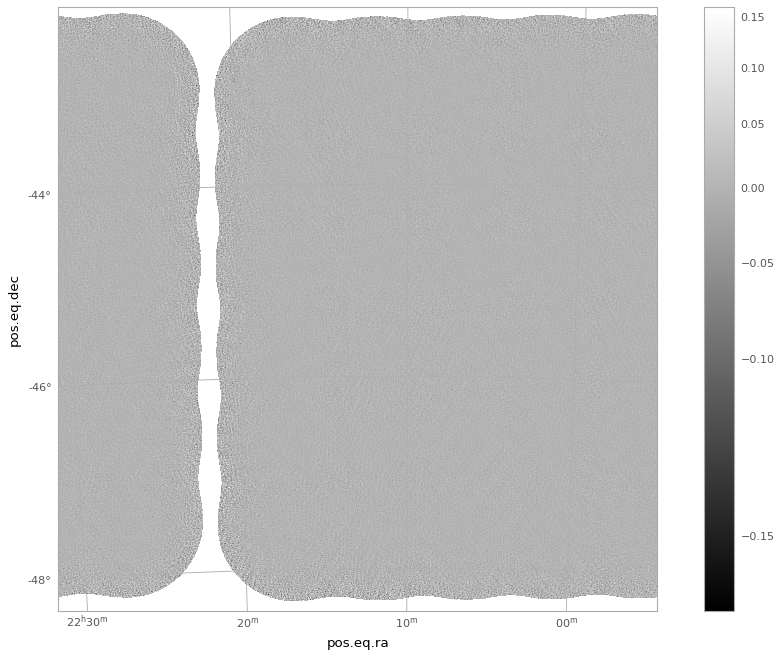

In [36]:
x=image_data[0,0,:,:]
import matplotlib.pyplot as pl
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure(figsize=(15,10), dpi= 80)
plt.subplot(projection=wcs, slices=('x', 'y', 0,0))
plt.imshow(x, cmap='gray', norm=norm)
plt.colorbar()

### Example 2 - smaller images, for ten channels

Now that we know how to extract a subset of full images over a predetermined number of channels, lets try a more complex example. Firstly, whats the range of the original cube? The positional and channel data has been saved into the table sparkfits_detail_arrays as part of the ETL data load process. Lets have a look at the table.

Here's the table schema

In [37]:
sqlContext.sql("desc sparkfits_detail_arrays").show()

+--------------------+------------+-------+
|            col_name|   data_type|comment|
+--------------------+------------+-------+
|    sda_detail_array|array<float>|   null|
|        sda_filename|      string|   null|
|     sda_detail_type|      string|   null|
|# Partition Infor...|            |       |
|          # col_name|   data_type|comment|
|        sda_filename|      string|   null|
|     sda_detail_type|      string|   null|
+--------------------+------------+-------+



Now lets have a look at the data

In [38]:
sqlContext.sql("select sda_filename, sda_detail_type, sda_detail_array from sparkfits_detail_arrays").show()

+--------------------+---------------+--------------------+
|        sda_filename|sda_detail_type|    sda_detail_array|
+--------------------+---------------+--------------------+
|residual.i.SB8170...|            GHz|[1.2955, 1.295518...|
|residual.i.SB8170...|             Hz|[1.29550003E9, 1....|
|residual.i.SB8170...|         km s-1|[-1.94190534E12, ...|
|residual.i.SB8170...|            GHz|[1.2955, 1.295518...|
|residual.i.SB8170...|             Hz|[1.29550003E9, 1....|
|residual.i.SB8170...|         km s-1|[-1.94190534E12, ...|
|image.restored.i....|       DEC--SIN|[-48.329792, -48....|
|image.restored.i....|       DEC--SIN|[-48.329792, -48....|
|image.restored.i....|       RA---SIN|[337.9597, 337.95...|
|image.restored.i....|       RA---SIN|[337.9597, 337.95...|
|residual.i.SB8170...|       RA---SIN|[59.229744, 59.22...|
|residual.i.SB8170...|       RA---SIN|[59.229744, 59.22...|
|residual.i.SB8170...|       DEC--SIN|[-27.01964, -27.0...|
|residual.i.SB8170...|       DEC--SIN|[-

What we can see here is that we have the positional data for every file loaded into the images table, sparkfits_images, as well as multiple arrays for channel and frequency data. The original cube had frequency data in Hz, but using the SpectralCube package we also recorded spectra values for velocity and GHz. 

We'll continue to use Hz data; these additional spectra values were created to demonstrate the capability of the data model to support multiple positional and channel formats.

Lets extract the positional and frequency array data for our cube. Remember, we have already set the filename, position and frequency types above -

* fitsFilename='image.restored.i.SB2338.V2.cube.fits'
* raType='RA---SIN'
* decType='DEC--SIN'
* spectraType='Hz'

We do this by calling the function GetDetailArrays

In [39]:
raArray, decArray, spectraArray = GetDetailArrays(fitsFilename, raType, decType, spectraType)

So, what ranges do we have in this cube?

In [40]:
print("Range of Ra {} to {}".format( max(raArray), min(raArray)))
print("Range of Declination {} to {}".format( max(decArray), min(decArray)))
print("Frequency ranges in {} - {} {}".format(spectraType, min(spectraArray), max(spectraArray))) 

Range of Ra 337.9596862792969 to 328.57586669921875
Range of Declination -42.05752944946289 to -48.32979202270508
Frequency ranges in Hz - 1376499968.0 1424481536.0


Converting between degrees and HMS for right ascension - we could write our own utilities but why reinvent the wheel? For these examples, there's a couple of functions from http://www.bdnyc.org/2012/10/decimal-deg-to-hms/ written by Joe Filippazzo that'll do the trick. You can write your own if you feel so inclined.

Converting the Right Ascension in degrees into HH:MM:SS

In [41]:
print("Range of Ra in hh:mm:ss {} to {}".format( deg2HMS(ra=max(raArray)), deg2HMS(ra=min(raArray))  ))


Range of Ra in hh:mm:ss 22 31 50.324707031244884 to 21 54 18.208007812501705


Now we have the range of the cube. Note that the array indexes match the position and spectra values from the original cube. This becomes important later, as we will see.

Lets assume we're interested in the position range between Right Ascension 22h10m and 22h20m and declination -46 to -47 degrees, for channel frequencies we want the frequency data between 1376759296 and 1376870400 Hz.

What Ra range in degrees do we want?

In [42]:
print("Required range of Ra in degrees - {} to {}".format( HMS2deg(ra='22 10 00.000'), HMS2deg(ra='22 20 00.000')))   

Required range of Ra in degrees - 332.5 to 335.0


#### Using the dimension table to extract declination and spectra values

Let's have a look at the declination and spectra position table, sparkfits_new_position_dimension.

In [43]:
sqlContext.sql("desc sparkfits_new_position_dimension").show()

+--------------------+------------+-------+
|            col_name|   data_type|comment|
+--------------------+------------+-------+
|     spd_declination|       float|   null|
|spd_declination_s...|array<float>|   null|
|        spd_filename|      string|   null|
|   spd_position_type|      string|   null|
|    spd_spectra_type|      string|   null|
|# Partition Infor...|            |       |
|          # col_name|   data_type|comment|
|        spd_filename|      string|   null|
|   spd_position_type|      string|   null|
|    spd_spectra_type|      string|   null|
+--------------------+------------+-------+



A look at the actual data in the dimension table. 

#### Note
This table is physically partitioned as well, on filename, declination coordinate type and spectra type. We have done this to enable the table structures to seamlessly hold data form differing coordinate systems as well as different spectra types if the original FITS cube has the capabillity to store the data in disparate coordinate systems.

#### Another note
Remember to include the order by clause; as we have mentioned earlier that unless explicity defined, spark will not return the dataframe in the order you require.

In [44]:
sqlContext.sql("""
    select
    *
    from sparkfits_new_position_dimension
    where spd_filename='{}'
    and spd_position_type='{}'
    and spd_spectra_type='{}'
    order by spd_declination desc
""".format(fitsFilename, decType,spectraType)).show()

+---------------+-----------------------+--------------------+-----------------+----------------+
|spd_declination|spd_declination_spectra|        spd_filename|spd_position_type|spd_spectra_type|
+---------------+-----------------------+--------------------+-----------------+----------------+
|      -42.05753|   [0.0, 5654.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.05864|   [1.0, 5655.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.05975|   [2.0, 5656.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.06086|   [3.0, 5657.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.06197|   [4.0, 5658.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.06308|   [5.0, 5659.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|     -42.064194|   [6.0, 5660.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|     -42.065304|   

Let's examine the position dataframe that we have returned above. The columns spd_filename, spd_position_type and spd_spectra_type are partitioned index columns to select the data subsets. In order to get the positional data we're interested in (ie the declination ranges and the specific frequencies we have specific previously)

We can select the declination range -46 to -47 easily, as below

In [45]:
sqlContext.sql("""
    select
    *
    from sparkfits_new_position_dimension
    where spd_filename='{}'
    and spd_position_type='{}'
    and spd_spectra_type='{}'
    and spd_declination <= -46
    and spd_declination >= -47 
    order by spd_declination desc
""".format(fitsFilename, decType,spectraType)).show()

+---------------+-----------------------+--------------------+-----------------+----------------+
|spd_declination|spd_declination_spectra|        spd_filename|spd_position_type|spd_spectra_type|
+---------------+-----------------------+--------------------+-----------------+----------------+
|     -46.000446|   [3554.0, 9208.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.001556|   [3555.0, 9209.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.002666|   [3556.0, 9210.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.003777|   [3557.0, 9211.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.004883|   [3558.0, 9212.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.005993|   [3559.0, 9213.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.007103|   [3560.0, 9214.0, ...|image.restored.i....|         DEC--SIN|              Hz|
|     -46.008213|   

That gives us our declination range. Inspect the array column spd_declination_spectra. This array contains the index number of the images table corresponding to the declination and spectra band.

As an example - if we take the spd_declination -46.008213 above, the first two elements in the spd_declination_spectra are [3561.0, 9215.0, ...

The index of this array corresponds to the frequency from the FITS cube - extrapolating, the spd_declination_spectra[0] value of 3561 corresponds to the row of data from the images table that represents all Ra values for declination  -46.008213 degrees for the frequency 1376499968.0 Hz.

The frequency range we require for our new cube are 1376759296 and 1376870400 Hz. An examination of the spectraArray will give the index positions we're interested in.

In [46]:
specRange = [1376759296, 1376870400]
specSelectRange=np.where(np.logical_and(spectraArray>=specRange[0], spectraArray<=specRange[1]))
specIdx=specSelectRange[0]
print(specIdx)
minIndex=min(specIdx)
maxIndex=max(specIdx)
print(minIndex, maxIndex)

[14 15 16 17 18 19 20]
14 20


So - we create a dataframe with the band indexes. First, we create a list from the specIdx array. Then we create a row object, and create the labelled dataframe, and create a temporary table we can use to generate the index ranges we want.

In [47]:
x=specIdx.tolist()
bandRDD=sc.parallelize(x)
row = Row("band") 
bandDF=bandRDD.map(row).toDF().registerTempTable("BandIndexes")


In [48]:
sqlContext.sql("select * from BandIndexes").show()

+----+
|band|
+----+
|  14|
|  15|
|  16|
|  17|
|  18|
|  19|
|  20|
+----+



So - now we know that the frequency bands we want correspond to spd_declination_spectra indexes 14 - 40. With this information we can now get the accurate index range we want to get the data from the sparkfits_images table. We also want the maximum declination we are selecting to use to reset the CRPIX value when we create a new header.

In [91]:
sqlContext.sql("""
    with AllPosData as
    (
        select
            *
        from sparkfits_new_position_dimension
        where spd_filename='{}'
        and spd_position_type='{}'
        and spd_spectra_type='{}'
        and spd_declination <= -46
        and spd_declination >= -47 
        order by spd_declination desc
    )
    select 
        max(spd_declination) as referenceDeclination,
        min(a.spd_declination_spectra[b.band]) as loIndex,
        max(a.spd_declination_spectra[b.band]) as hiIndex
    from AllPosData a
        cross join BandIndexes b
    group by band
    order by band

""".format(fitsFilename, decType,spectraType, minIndex, maxIndex)).show()

+--------------------+--------+--------+
|referenceDeclination| loIndex| hiIndex|
+--------------------+--------+--------+
|          -46.000446| 82710.0| 83611.0|
|          -46.000446| 88364.0| 89265.0|
|          -46.000446| 94018.0| 94919.0|
|          -46.000446| 99672.0|100573.0|
|          -46.000446|105326.0|106227.0|
|          -46.000446|110980.0|111881.0|
|          -46.000446|116634.0|117535.0|
+--------------------+--------+--------+



Which now gives us direct access to the images table via the indexes. So, this is one way to get the data - we create a temporary table in memory and use it to join to the images table to get the data we want. This is the same query as the one above.

In [93]:
sqlContext.sql("""
    with AllPosData as
    (
        select
            *
        from sparkfits_new_position_dimension
        where spd_filename='{}'
        and spd_position_type='{}'
        and spd_spectra_type='{}'
        and spd_declination <= -46
        and spd_declination >= -47 
        order by spd_declination desc
    )
    select
        band,
        max(spd_declination) as referenceDeclination,
        min(a.spd_declination_spectra[b.band]) as loIndex,
        max(a.spd_declination_spectra[b.band]) as hiIndex
    from AllPosData a
        cross join BandIndexes b
    group by band
    order by band
""".format(fitsFilename, decType,spectraType, minIndex, maxIndex)).registerTempTable("Indexes")

In [94]:
sqlContext.sql("select * from Indexes").show()

+----+--------------------+--------+--------+
|band|referenceDeclination| loIndex| hiIndex|
+----+--------------------+--------+--------+
|  14|          -46.000446| 82710.0| 83611.0|
|  15|          -46.000446| 88364.0| 89265.0|
|  16|          -46.000446| 94018.0| 94919.0|
|  17|          -46.000446| 99672.0|100573.0|
|  18|          -46.000446|105326.0|106227.0|
|  19|          -46.000446|110980.0|111881.0|
|  20|          -46.000446|116634.0|117535.0|
+----+--------------------+--------+--------+



Now we can get the data from the cube we want. 

First, though, we need to create the band array we want to use in the query; the sparkfits_images table has data from multiple cubes and is therefore physically partitioned on filename and spectra band. Explicitly specifying the filename and band means we do a partition read, not a full table scan. A full table scan should be avoided at all costs (unless you want all of the data in the table. Unlikely, but possible if you really want it.) so we explicitly specify which bands we want.

The specIdx array gives us the bands we want; but we need to convert it to a string we can use in the SQL statement.

In [52]:
bandString='('
for i in np.arange(len(specIdx)):
    if i ==0:
        bandString = bandString + str(specIdx[i])
    else:
        bandString=bandString+','+ str(specIdx[i])
        pass
    
bandString=bandString + ')'

In [53]:
bandString

'(14,15,16,17,18,19,20)'

In [54]:
sqlContext.sql("""select spi_index, spi_image , spi_band
from sparkfits_images a
    inner join Indexes b
        on a.spi_band=b.band
            and spi_index >=b.loIndex 
            and spi_index <=b.hiIndex
where spi_filename='{}' 
and spi_band in {}
order by spi_index""".format(fitsFilename, bandString)).show()

+---------+--------------------+--------+
|spi_index|           spi_image|spi_band|
+---------+--------------------+--------+
|    82710|[4.324964E-4, 0.0...|      14|
|    82711|[0.0029689448, 0....|      14|
|    82712|[0.0049807825, 0....|      14|
|    82713|[0.0065743416, 0....|      14|
|    82714|[0.007819243, 0.0...|      14|
|    82715|[0.008692556, 0.0...|      14|
|    82716|[0.009111639, 0.0...|      14|
|    82717|[0.009015059, 0.0...|      14|
|    82718|[0.008432653, 0.0...|      14|
|    82719|[0.0075027905, 0....|      14|
|    82720|[0.0064318804, 0....|      14|
|    82721|[0.0054244697, 0....|      14|
|    82722|[0.004624912, 0.0...|      14|
|    82723|[0.0040991385, 0....|      14|
|    82724|[0.0038565889, 0....|      14|
|    82725|[0.003885133, 0.0...|      14|
|    82726|[0.004164086, 0.0...|      14|
|    82727|[0.0046393997, 0....|      14|
|    82728|[0.005179768, 0.0...|      14|
|    82729|[0.0055574705, 0....|      14|
+---------+--------------------+--

All well and good: but this is still giving us the full RA spread which is not what we want. The Ra spread we want was specified as 22h 10m to 22h 20m (which we calculated as 332.5 - 335 degrees).

The raArray can give us the correct indexes - we use the np.logical_and function to get the indexes of the RA values we want and turn it into a list.

In [55]:
raSelectRange=np.where(np.logical_and(raArray>=332.5, raArray<=335))
raSelectList=raSelectRange[0].tolist()
raSelectList

[1770,
 1771,
 1772,
 1773,
 1774,
 1775,
 1776,
 1777,
 1778,
 1779,
 1780,
 1781,
 1782,
 1783,
 1784,
 1785,
 1786,
 1787,
 1788,
 1789,
 1790,
 1791,
 1792,
 1793,
 1794,
 1795,
 1796,
 1797,
 1798,
 1799,
 1800,
 1801,
 1802,
 1803,
 1804,
 1805,
 1806,
 1807,
 1808,
 1809,
 1810,
 1811,
 1812,
 1813,
 1814,
 1815,
 1816,
 1817,
 1818,
 1819,
 1820,
 1821,
 1822,
 1823,
 1824,
 1825,
 1826,
 1827,
 1828,
 1829,
 1830,
 1831,
 1832,
 1833,
 1834,
 1835,
 1836,
 1837,
 1838,
 1839,
 1840,
 1841,
 1842,
 1843,
 1844,
 1845,
 1846,
 1847,
 1848,
 1849,
 1850,
 1851,
 1852,
 1853,
 1854,
 1855,
 1856,
 1857,
 1858,
 1859,
 1860,
 1861,
 1862,
 1863,
 1864,
 1865,
 1866,
 1867,
 1868,
 1869,
 1870,
 1871,
 1872,
 1873,
 1874,
 1875,
 1876,
 1877,
 1878,
 1879,
 1880,
 1881,
 1882,
 1883,
 1884,
 1885,
 1886,
 1887,
 1888,
 1889,
 1890,
 1891,
 1892,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,

Putting it all together!

#### Create the declination and band dataframe

As the example above

In [56]:
imageDF=sqlContext.sql("""
select
    a.*
from sparkfits_images a
    inner join Indexes b
        on a.spi_band=b.band
            and spi_index >=b.loIndex 
            and spi_index <=b.hiIndex
where spi_filename='{}' 
and spi_band in {}
order by spi_index""".format(fitsFilename, bandString))


In [57]:
imageDF.show()

+---------+--------------------+--------------------+--------+
|spi_index|           spi_image|        spi_filename|spi_band|
+---------+--------------------+--------------------+--------+
|    82710|[4.324964E-4, 0.0...|image.restored.i....|      14|
|    82711|[0.0029689448, 0....|image.restored.i....|      14|
|    82712|[0.0049807825, 0....|image.restored.i....|      14|
|    82713|[0.0065743416, 0....|image.restored.i....|      14|
|    82714|[0.007819243, 0.0...|image.restored.i....|      14|
|    82715|[0.008692556, 0.0...|image.restored.i....|      14|
|    82716|[0.009111639, 0.0...|image.restored.i....|      14|
|    82717|[0.009015059, 0.0...|image.restored.i....|      14|
|    82718|[0.008432653, 0.0...|image.restored.i....|      14|
|    82719|[0.0075027905, 0....|image.restored.i....|      14|
|    82720|[0.0064318804, 0....|image.restored.i....|      14|
|    82721|[0.0054244697, 0....|image.restored.i....|      14|
|    82722|[0.004624912, 0.0...|image.restored.i....|  

Now we apply the filter to extract the RA values we want, which we calculated into the list raSelectList above.

In [58]:
newCube1DF=imageDF.withColumn("raSelectRange", f.array([f.col("spi_image")[i] for i in raSelectList  ] ))\
.select(col("spi_index"),"raSelectRange")

In [60]:
newCube1DF.show()

+---------+--------------------+
|spi_index|       raSelectRange|
+---------+--------------------+
|    82710|[0.02397355, 0.02...|
|    82711|[0.023120357, 0.0...|
|    82712|[0.02040923, 0.02...|
|    82713|[0.016336223, 0.0...|
|    82714|[0.011531271, 0.0...|
|    82715|[0.006626066, 0.0...|
|    82716|[0.002172301, 0.0...|
|    82717|[-0.001394868, 0....|
|    82718|[-0.0037748886, -...|
|    82719|[-0.00482045, -0....|
|    82720|[-0.0045542405, -...|
|    82721|[-0.0031698344, -...|
|    82722|[-0.0010085909, -...|
|    82723|[0.0015009128, 0....|
|    82724|[0.0038519602, 0....|
|    82725|[0.005610543, 0.0...|
|    82726|[0.0064419582, 0....|
|    82727|[0.006232804, 0.0...|
|    82728|[0.005088944, 0.0...|
|    82729|[0.0032734044, 0....|
+---------+--------------------+
only showing top 20 rows



In [61]:
newCube1DF.count()

6314

So, now we have the data cube we want. Let's extract the data and create the new header

In [62]:
data=np.array(newCube1DF.select(col('raSelectRange')).collect())

In [63]:
data.shape

(6314, 1, 1493)

In [64]:
len(specIdx)

7

In [65]:
len(raSelectRange[0])

1493

In [66]:
decSelectRange=np.where(np.logical_and(decArray>=-47, decArray<=-46))

In [67]:
len(decSelectRange[0])

902

In [68]:
len(decSelectRange[0]) * len(specIdx)

6314

In [69]:
#data=data.reshape(data.shape[0], data.shape[2])
data=data.reshape(len(specIdx), 1, len(decSelectRange[0]), len(raSelectRange[0]))

In [173]:
data.shape

(7, 1, 902, 1493)

In [191]:
newhdu=fits.PrimaryHDU(data=data)
newheader=newhdu.header

In [192]:
newheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1493                                                  
NAXIS2  =                  902                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    7                                                  
EXTEND  =                    T                                                  

Fill out the new header with the information from the original file header, which we created as retrievedHeader in the example above.

In [193]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
for i in np.arange(len(retrievedHeader)):
    try:
        newheader[list(retrievedHeader.keys())[i]]
        # print("Exists!", list(jheader.keys())[i], jheader[int(i)],  jheader.comments[int(i)])
    except Exception as e:
        # print(list(header.keys())[i], header[int(i)],  header.comments[int(i)])
        jkey = list(retrievedHeader.keys())[i]
        
        if isFloat(retrievedHeader[int(i)]):
            jval=float(retrievedHeader[int(i)])
            pass
        elif retrievedHeader[int(i)].isnumeric():
            v=int(row.value)
            pass
        else:
            jval = retrievedHeader[int(i)]
            
        
        jcom = retrievedHeader.comments[int(i)]
        
        newheader[jkey] = (jval, jcom)

In [183]:
newheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1493                                                  
NAXIS2  =                  902                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    7                                                  
EXTEND  =                    T                                                  
BSCALE  =                  1.0 / PHYSICAL = PIXEL*BSCALE + BZERO                
BZERO   =                  0.0                                                  
BUNIT   = 'Jy/beam '           / Brightness (pixel) unit                        
EQUINOX =               2000.0                                                  
RADESYS = 'FK5     '        

### Creating new header information

Now that we have created the new header, we need to modify the position information so when we create the new WCS, it acurately reflects the data in the cube so we can generate a position overlay. 

In order to calculate this, we need the maximum Ra position declination positions in degrees, so we can calculate the new CRPIXn values. Let's continue.

#### Calculating the new Ra CRPIX value

We have the indexes we want from the raSelectRange array, and the raArray array containes the positins in degrees for this cube. So to get the max Ra value, we want the raArray value with the index of the first position contained in the raSelectRange array.

In [86]:
raSelectRange

(array([1770, 1771, 1772, ..., 3260, 3261, 3262]),)

In [87]:
maxRaIndex=raSelectRange[0][0]
maxRaIndex

1770

therefore, this value is the new reference position for Ra in the new cube.

In [162]:
newRaRef=raArray[maxRaIndex]
newRaRef

334.9989318847656

#### Calculating the new Dec CRPIX value

We saved this value into the Indexes temporary tble as the column "referenceDeclination"

In [95]:
sqlContext.sql("select max(referenceDeclination) from Indexes").show()

+--------------------+
|referenceDeclination|
+--------------------+
|          -46.000446|
+--------------------+



In [102]:
newDecRef=sqlContext.sql("select max(referenceDeclination) from Indexes").collect()[0][0]
newDecRef

-46.00044631958008

#### Calculate the new Spectra CRPIX value

The specIdx array has the indexes of the frequences we want

In [194]:
specIdx

array([14, 15, 16, 17, 18, 19, 20])

So we want the frequency from band 14, or the minimum frequency in our band selection. spectraArray as the frequeny details for this cube, so the frequency we want ot use as rge new reference point is spectraArray[min(specIdx)]

In [106]:
newSpectraRef=spectraArray[min(specIdx)]
newSpectraRef

1376759296.0

With these values, we can use the wsc_world2pix function to calculate the new CRPIX values we want.

First, we create a WCS object from the original file header, retrievedHeader

In [114]:
raArray

array([337.95968628, 337.95803833, 337.95635986, ..., 328.57922363,
       328.57754517, 328.5758667 ])

In [115]:
decArray

array([-48.32979202, -48.32868195, -48.32757187, ..., -42.0597496 ,
       -42.05863953, -42.05752945])

In [113]:
retrievedHeader

SIMPLE  =                    T / Standard FITS                                  
BITPIX  =                -32.0 / Floating point (32 bit)                        
NAXIS   =                  4.0                                                  
EXTEND  =                    T                                                  
NAXIS1  =               5607.0                                                  
NAXIS2  =               5654.0                                                  
NAXIS3  =                  1.0                                                  
NAXIS4  =               2592.0                                                  
BSCALE  =                  1.0 / PHYSICAL = PIXEL*BSCALE + BZERO                
BZERO   =                  0.0                                                  
BUNIT   = 'Jy/beam '           / Brightness (pixel) unit                        
EQUINOX =               2000.0                                                  
RADESYS = 'FK5     '        

In [195]:
wcs=WCS(retrievedHeader)

In [196]:
newRaRef, newDecRef, newSpectraRef

(334.9989318847656, -46.00044631958008, 1376759296.0)

In [197]:
refriedBeans= wcs.wcs_world2pix(newRaRef,newDecRef,1,newSpectraRef,1, ra_dec_order=True)

In [198]:
refriedBeans

[array(1705.37109116), array(2178.07299594), array(0.), array(-74330.00208473)]

In [199]:
#newheader["CRVAL1"] = newRaRef
#newheader["CRVAL2"] = newDecRef
#newheader["CRVAL4"] = newSpectraRef
newheader["CRPIX1"] = float(refriedBeans[0])
newheader["CRPIX2"] = float(refriedBeans[1])
newheader["CRPIX4"] = 15#float(refriedBeans[3])

In [200]:
newheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1493                                                  
NAXIS2  =                  902                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    7                                                  
EXTEND  =                    T                                                  
BSCALE  =                  1.0 / PHYSICAL = PIXEL*BSCALE + BZERO                
BZERO   =                  0.0                                                  
BUNIT   = 'Jy/beam '           / Brightness (pixel) unit                        
EQUINOX =               2000.0                                                  
RADESYS = 'FK5     '        

In [201]:
newhdu.writeto('/mnt/FITs/wcsTEST.fits')

And test

In [202]:
filePath="/mnt/FITs/wcsTEST.fits"


fits.info(filePath)
hduTest=fits.open(filePath , memmap=True)
headerTest=hduTest[0].header
wcs=WCS(headerTest)
cubeHz = SpectralCube.read(hduTest)

image_data = hduTest[0].data

hduTest.close()

Filename: /mnt/FITs/wcsTEST.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      68   (1493, 902, 1, 7)   float64   


In [203]:
image_data.shape

(7, 1, 902, 1493)

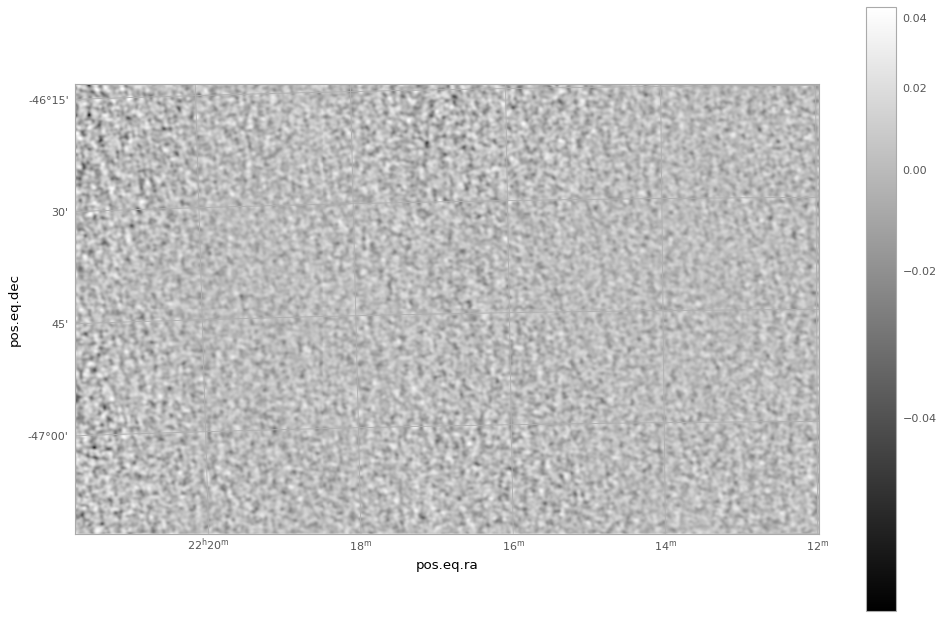

In [204]:
x=image_data[0,0,:,:]
import matplotlib.pyplot as pl
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure(figsize=(15,10), dpi= 80)
plt.subplot(projection=wcs, slices=('x', 'y', 0,0))
plt.imshow(x, cmap='gray', norm=norm)
plt.colorbar()

In [205]:
wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 332.6475708333  -44.83073888889  1.0  1376500000.056  
CRPIX : 1705.371091155125  2178.072995937247  1.0  15.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.001111111111111  0.001111111111111  1.0  18518.51799989  
NAXIS : 1493  902  1  7